In [2]:
import muon as mu
import numpy as np
import pandas as pd
import scanpy as sc
from scipy.sparse import csr_matrix
import anndata as ad
from matplotlib import pyplot as plt
import seaborn as sns
print(ad.__version__)

/home/diamant/.conda/envs/iso_swt/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/diamant/.conda/envs/iso_swt/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/diamant/.conda/envs/iso_swt/lib/python3.9/site-packages/umap/distanc

0.10.3


Read adata object from file:

In [3]:
adata_gen = ad.read_h5ad('./write/brain_mouse_190.h5ad')

In [4]:
with open("./data/GSM3748087_190c.isoforms.matrix.txt") as isoforms:
    df = pd.read_table(isoforms, sep='\t')

counts = df.iloc[0:,2:]
adata_iso = ad.AnnData(counts).transpose()
adata_iso.var_names = df['transcriptId'].to_list()
adata_iso.var = df[['transcriptId', 'geneId']]
barcodes = {'barcodes': df.columns.values[2:]}
barcodes = pd.DataFrame(data=barcodes)
adata_iso.obs = barcodes
adata_iso.obs_names = barcodes['barcodes'].tolist()

/home/diamant/.conda/envs/iso_swt/lib/python3.9/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [5]:
mdata = mu.MuData({'gen': adata_gen, 'iso': adata_iso})
mdata.mod['gen'].var['n_of_iso'] = mdata.mod['iso'].var.groupby(by='geneId').count()

In [6]:
sum(mdata.mod['gen'].var['n_of_iso'] > 1)

1213

<Axes: xlabel='genes with multiple isoforms', ylabel='quantity of genes'>

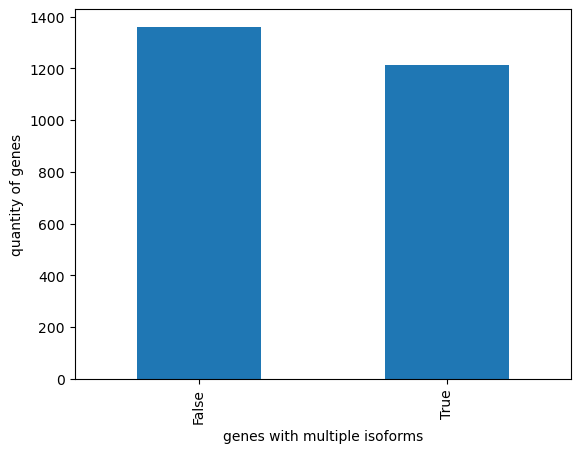

In [7]:
fig, ax = plt.subplots()
(mdata.mod['gen'].var['n_of_iso'] > 1).value_counts().plot(ax=ax, kind='bar', 
                                                     xlabel='genes with multiple isoforms', ylabel='quantity of genes')

In [8]:
x = ['genes']
multiple_iso = sum(mdata.mod['gen'].var['n_of_iso'] > 1)
mono_iso = sum((mdata.mod['gen'].var['n_of_iso'] > 1) == False)


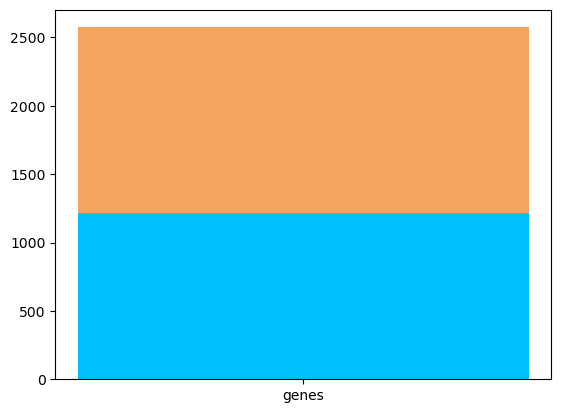

In [9]:

plt.bar(x, multiple_iso, color = 'deepskyblue', label = "multiple_iso") #multiple_iso/(multiple_iso+mono_iso))
plt.bar(x, mono_iso, bottom=multiple_iso, color='sandybrown', label = "mono iso") #mona_iso/(multiple_iso+mono_iso))
ax.legend()
ax.set_ylabel('Number of genes')
plt.show()

<Axes: xlabel='number of isoforms per gene', ylabel='quantity of genes'>

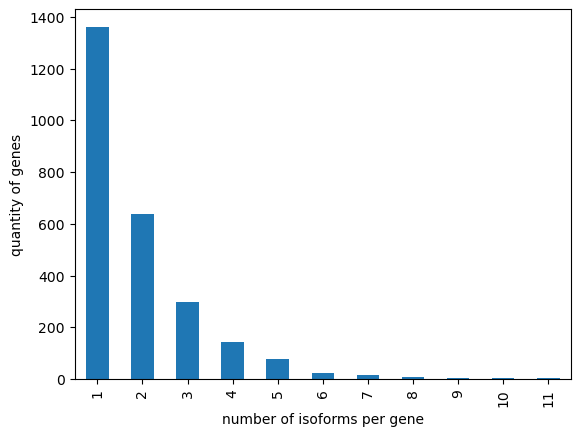

In [10]:
# count total frequencis of genes having 1 , 2 , 3 , ... n isoforms
fig, ax = plt.subplots()

mdata.mod['gen'].var['n_of_iso'].value_counts().plot(ax=ax, kind='bar', 
                                                     xlabel='number of isoforms per gene', ylabel='quantity of genes')

In [11]:
# number of cells in each cluster:
mdata.mod['gen'].obs.groupby(by ='leiden').count()

/tmp/ipykernel_569482/2181675490.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mdata.mod['gen'].obs.groupby(by ='leiden').count()


,barcodes
leiden,
Radial glia,38
Imature glutamatergic,28
Mature glutamatergic,27
Imature GABAergic,26
Cajal Retzius,26
Cycling Radial glia,20
mature GABAergic,20
intermediate progenitor,5


In [12]:
# boxplot with number of genes expressed per cell type:
adata_gen.obs["cell_type"] = pd.Categorical(adata_gen.obs['leiden'].to_list())


In [13]:
# mdata.mod['gen'].to_df(layer=None)
mdata.mod['gen'].obs['cell_type'].unique()

['Cycling Radial glia', 'Radial glia', 'intermediate progenitor', 'Imature glutamatergic', 'Mature glutamatergic', 'mature GABAergic', 'Imature GABAergic', 'Cajal Retzius']
Categories (8, object): ['Cajal Retzius', 'Cycling Radial glia', 'Imature GABAergic', 'Imature glutamatergic', 'Mature glutamatergic', 'Radial glia', 'intermediate progenitor', 'mature GABAergic']

In [14]:
# copy cell types labels identified on genes to isoform matrix:
mdata.mod['iso'].obs['cell_type'] = mdata.mod['gen'].obs['cell_type']

In [15]:
mdata.mod['iso'].obs

,barcodes,cell_type
CAACTAGAGCTGTTCA,CAACTAGAGCTGTTCA,Cycling Radial glia
CCACCTACAAAGTCAA,CCACCTACAAAGTCAA,Radial glia
AACCATGAGACCACGA,AACCATGAGACCACGA,intermediate progenitor
GATGAGGTCGACCAGC,GATGAGGTCGACCAGC,Imature glutamatergic
GCACTCTTCTATCGCC,GCACTCTTCTATCGCC,Mature glutamatergic
...,...,...
AAGACCTAGATTACCC,AAGACCTAGATTACCC,Imature glutamatergic
CTGAAGTAGGTAGCTG,CTGAAGTAGGTAGCTG,mature GABAergic
TAGTGGTAGGCCCTTG,TAGTGGTAGGCCCTTG,Imature glutamatergic
GATGAAAAGCAATATG,GATGAAAAGCAATATG,Radial glia


### Reduce the gene matrix to switching genes (gens that are expressed by more then one isoform)

In [16]:
# names of genes that are expressed by multiple isoforms:
multi_iso_genes = mdata.mod['gen'].var['n_of_iso'] > 1
multi_iso_genes = multi_iso_genes[multi_iso_genes == True]
multi_iso_genes

geneId
2810403A07Rik    True
Abcc5            True
Abhd10           True
Abhd11           True
Abhd13           True
                 ... 
Zkscan3          True
Zkscan5          True
Zmynd8           True
Zscan26          True
Zzz3             True
Name: n_of_iso, Length: 1213, dtype: bool

In [17]:
mdata.mod['gen'].var['multi_iso'] = mdata.mod['gen'].var['n_of_iso'] > 1
mdata.mod['gen'].var['multi_iso'][mdata.mod['gen'].var['multi_iso'] == True]
mdata.mod['iso'].var['multi_iso'] = mdata.mod['gen'].var['n_of_iso'] > 1

/tmp/ipykernel_569482/1727728676.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mdata.mod['iso'].var['multi_iso'] = mdata.mod['gen'].var['n_of_iso'] > 1


### !!!! Filtering didn't work. TO DO!

In [18]:
gene_m = mdata.mod['gen'][:, mdata.mod['gen'].var['multi_iso'] == True]
gene_iso_m = mdata.mod['iso'][:, mdata.mod['iso'].var['multi_iso'] == True]
mdata_m = mu.MuData({'gen': gene_m, 'iso': gene_iso_m})

/home/diamant/.conda/envs/iso_swt/lib/python3.9/site-packages/mudata/_core/mudata.py:577: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_common = pd.concat(


In [19]:


def iso_percent(input, barcodes_regex="^[ACGT]+$"):
    # df = None
    # def is_df(var):
    #     return var is pd.DataFrame
    # def is_adata(var):
    #     return var is ad.AnnData
    # if is_df(input):
    #     df = input
    # elif is_adata(input):

    iso_perc_df = input.__deepcopy__()
    if len(iso_perc_df.filter(regex=(barcodes_regex)).columns.to_list()) < 1:
        raise ValueError("No barcode was identified. Please check the names of the columns.")
    iso_perc_df[iso_perc_df.filter(regex=(barcodes_regex)).columns.to_list()] = iso_perc_df.filter(regex=(barcodes_regex)) / iso_perc_df.groupby(['geneId']).transform('sum').filter(regex=(barcodes_regex))
    iso_perc_df = iso_perc_df.replace(np.nan, 0.0)
    return iso_perc_df


In [20]:
with open("./data/GSM3748087_190c.isoforms.matrix.txt") as isoforms:
    df = pd.read_table(isoforms, sep='\t')
    matrix = input
    df_m = df[df['geneId'].isin(multi_iso_genes)]
    df_m.head()

Iso_percent is a function that takes as an input a count matrix with gene names and isoforms and count the percentage that every one of isoforms correspond in the total transcript counts from a gene. The output is a dataframe.


In [21]:
# Create a matrix with the percentage of isoform from the summ of all the isoforms from the same gene in every cell:
# We impose that barcodes corresponding to cells are all composed of only ACTG capital characters without underscores or any other symbols
def iso_percent(df, barcodes_regex="^[ACGT]+$"):
    iso_perc_df = df.__deepcopy__()
    if len(iso_perc_df.filter(regex=(barcodes_regex)).columns.to_list()) < 1:
        raise ValueError("No barcode was identified. Please check the names of the columns.")
    iso_perc_df[iso_perc_df.filter(regex=(barcodes_regex)).columns.to_list()] = iso_perc_df.filter(regex=(barcodes_regex)) / iso_perc_df.groupby(['geneId']).transform('sum').filter(regex=(barcodes_regex))
    iso_perc_df = iso_perc_df.replace(np.nan, 0.0)
    return iso_perc_df
df_m_iso = iso_percent(df)
df_m_iso[df_m_iso['geneId']=='Stmn1']

,geneId,transcriptId,CAACTAGAGCTGTTCA,CCACCTACAAAGTCAA,AACCATGAGACCACGA,GATGAGGTCGACCAGC,GCACTCTTCTATCGCC,TGCCCTAAGGCCCGTT,TTCGGTCAGCTGGAAC,GGATTACAGACGCAAC,...,TCGGGACAGCCCAGCT,GTTACAGTCTCGATGA,ATCATGGAGAAGAAGC,CGCGTTTCAGCTGTAT,TTCTTAGAGATCTGCT,AAGACCTAGATTACCC,CTGAAGTAGGTAGCTG,TAGTGGTAGGCCCTTG,GATGAAAAGCAATATG,TTCTTAGTCTGTTGAG
52,Stmn1,ENSMUST00000030636.10,0.0,0.918367,0.916667,0.97619,0.892857,1.0,0.666667,0.920000,...,0.987013,0.875,0.954545,1.0,0.928571,0.984615,0.964286,0.888889,0.940594,0.923077
6739,Stmn1,ENSMUST00000105867.7,0.0,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.013333,...,0.000000,0.000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.012821
7076,Stmn1,ENSMUST00000105868.1,0.0,0.081633,0.083333,0.02381,0.107143,0.0,0.333333,0.066667,...,0.012987,0.125,0.045455,0.0,0.071429,0.015385,0.035714,0.111111,0.059406,0.064103
10650,Stmn1,ENSMUST00000130253.1,0.0,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
17656,Stmn1,ENSMUST00000127279.7,0.0,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [22]:
#df_m_iso = df_m_iso.set_index('transcriptId')
df_m_iso = df_m_iso.iloc[0:,2:]
df_m_iso

,CAACTAGAGCTGTTCA,CCACCTACAAAGTCAA,AACCATGAGACCACGA,GATGAGGTCGACCAGC,GCACTCTTCTATCGCC,TGCCCTAAGGCCCGTT,TTCGGTCAGCTGGAAC,GGATTACAGACGCAAC,GTCTCGTTCCTCTAGC,CCATGTCAGTAGATGT,...,TCGGGACAGCCCAGCT,GTTACAGTCTCGATGA,ATCATGGAGAAGAAGC,CGCGTTTCAGCTGTAT,TTCTTAGAGATCTGCT,AAGACCTAGATTACCC,CTGAAGTAGGTAGCTG,TAGTGGTAGGCCCTTG,GATGAAAAGCAATATG,TTCTTAGTCTGTTGAG
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20829,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20830,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20831,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
20832,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.8,1.0,1.0,1.0


Add percentage matrix to mdata object:

In [23]:
mdata.mod['iso'].obsm['Iso_prct'] = df_m_iso.transpose()

In [24]:
# just for example to Iso_prct method
mdata.mod['gen'].obsm['X_pca']

array([[-3.4976268 , -1.6554799 , -0.2497322 , ..., -0.5157702 ,
        -1.0701575 , -1.6421108 ],
       [-8.435176  ,  4.906905  , -1.7606857 , ..., 13.872809  ,
         6.4815645 , 10.103132  ],
       [-1.6495701 ,  5.2250843 ,  0.51213753, ...,  4.670171  ,
        -2.1230986 ,  0.8804985 ],
       ...,
       [-8.3322315 , -3.7244954 , -0.27430752, ...,  0.5117736 ,
        -0.46608466,  1.4141482 ],
       [-3.8459327 ,  4.733719  , -0.07414398, ..., -0.75334007,
         1.8794926 , -0.79862595],
       [-5.497597  ,  2.7288601 , -1.1445866 , ..., -0.1233312 ,
         3.1784673 ,  0.27161098]], dtype=float32)

In [25]:
mdata.mod['gen'].obs.groupby(by ='cell_type').count()
def grouped_obs_mean(adata, group_key, layer=None):
    if layer is not None:
        getX = lambda x: x.layers[layer]
    else:
        getX = lambda x: x.X

    grouped = adata.obs.groupby(group_key)
    out = pd.DataFrame(
        np.zeros((adata.shape[1], len(grouped)), dtype=np.float64),
        columns=list(grouped.groups.keys()),
        index=adata.var_names
    )

    for group, idx in grouped.indices.items():
        X = getX(adata[idx])
        out[group] = np.ravel(X.mean(axis=0, dtype=np.float64))
    return out

def get_mean_per_cell_type(geneId, mdata, mod='iso', grouping='cell_type', layer='Iso_prct'):
    grouped = mdata.mod[mod].to_df(layer).groupby(by = grouping)
    


/tmp/ipykernel_569482/2849214550.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mdata.mod['gen'].obs.groupby(by ='cell_type').count()


In [26]:
grouped = mdata.mod['iso'].obsm['Iso_prct']
grouped['cell_type'] = mdata.mod['iso'].obs['cell_type']
res = grouped.groupby('cell_type').mean().transpose()
res[['transcriptId', 'geneId']] = df[['transcriptId', 'geneId']]
res[res['geneId'] == 'Stmn1']


/tmp/ipykernel_569482/384331066.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  res = grouped.groupby('cell_type').mean().transpose()


cell_type,Cajal Retzius,Cycling Radial glia,Imature GABAergic,Imature glutamatergic,Mature glutamatergic,Radial glia,intermediate progenitor,mature GABAergic,transcriptId,geneId
52,0.933054,0.788843,0.927121,0.920369,0.896789,0.927263,0.896570,0.913724,ENSMUST00000030636.10,Stmn1
6739,0.002564,0.004412,0.002212,0.002744,0.004196,0.003121,0.003922,0.000000,ENSMUST00000105867.7,Stmn1
7076,0.062957,0.056746,0.070667,0.076887,0.099015,0.069292,0.099508,0.086276,ENSMUST00000105868.1,Stmn1
10650,0.001425,0.000000,0.000000,0.000000,0.000000,0.000172,0.000000,0.000000,ENSMUST00000130253.1,Stmn1
17656,0.000000,0.000000,0.000000,0.000000,0.000000,0.000152,0.000000,0.000000,ENSMUST00000127279.7,Stmn1


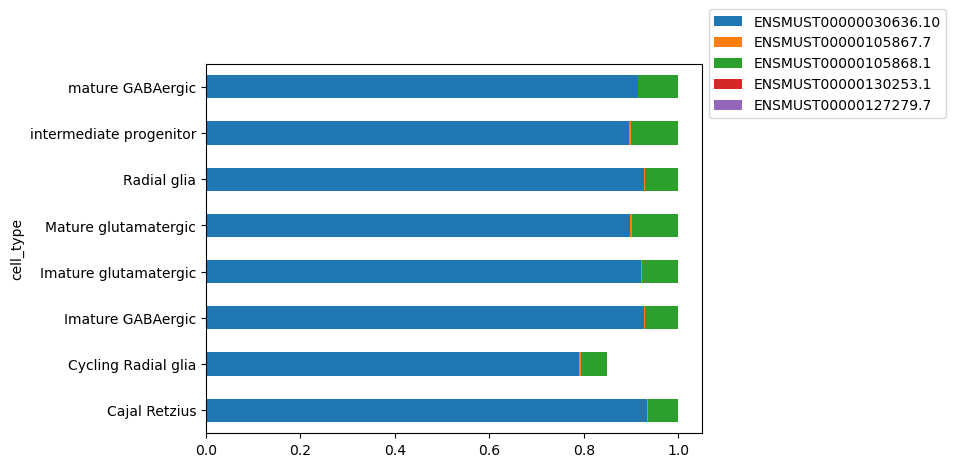

In [27]:
plot_data = res[res['geneId'] == 'Stmn1'].set_index('transcriptId').drop(['geneId'], axis=1).transpose()
plot_data.plot(kind='barh', stacked=True).legend(loc='center left',bbox_to_anchor=(1.0, 1.0))

In [28]:
mdata.mod['iso'].obsm['Iso_prct']

,0,1,2,3,4,5,6,7,8,9,...,20825,20826,20827,20828,20829,20830,20831,20832,20833,cell_type
CAACTAGAGCTGTTCA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cycling Radial glia
CCACCTACAAAGTCAA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Radial glia
AACCATGAGACCACGA,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,intermediate progenitor
GATGAGGTCGACCAGC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Imature glutamatergic
GCACTCTTCTATCGCC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Mature glutamatergic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AAGACCTAGATTACCC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Imature glutamatergic
CTGAAGTAGGTAGCTG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.034483,0.0,0.0,0.0,0.0,0.0,1.0,0.8,0.0,mature GABAergic
TAGTGGTAGGCCCTTG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Imature glutamatergic
GATGAAAAGCAATATG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Radial glia


Violing plot to compare the quantity of different transcripts between different cell types

In [37]:
# mdata.mod['iso'].X # anndata to dataframe as in df:
df[df['geneId']=='Stmn1']

,geneId,transcriptId,CAACTAGAGCTGTTCA,CCACCTACAAAGTCAA,AACCATGAGACCACGA,GATGAGGTCGACCAGC,GCACTCTTCTATCGCC,TGCCCTAAGGCCCGTT,TTCGGTCAGCTGGAAC,GGATTACAGACGCAAC,...,TCGGGACAGCCCAGCT,GTTACAGTCTCGATGA,ATCATGGAGAAGAAGC,CGCGTTTCAGCTGTAT,TTCTTAGAGATCTGCT,AAGACCTAGATTACCC,CTGAAGTAGGTAGCTG,TAGTGGTAGGCCCTTG,GATGAAAAGCAATATG,TTCTTAGTCTGTTGAG
52,Stmn1,ENSMUST00000030636.10,0,45,77,41,50,28,4,69,...,76,21,21,6,26,64,54,16,95,72
6739,Stmn1,ENSMUST00000105867.7,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
7076,Stmn1,ENSMUST00000105868.1,0,4,7,1,6,0,2,5,...,1,3,1,0,2,1,2,2,6,5
10650,Stmn1,ENSMUST00000130253.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17656,Stmn1,ENSMUST00000127279.7,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [77]:
gene_iso_count = df[df['geneId']=='Stmn1'].set_index('transcriptId').drop(['geneId'], axis=1).transpose()
gene_iso_count['cell_type'] = mdata.mod['iso'].obs['cell_type']
#gene_iso_count = gene_iso_count.groupby('cell_type')
gene_iso_count

transcriptId,ENSMUST00000030636.10,ENSMUST00000105867.7,ENSMUST00000105868.1,ENSMUST00000130253.1,ENSMUST00000127279.7,cell_type
CAACTAGAGCTGTTCA,0,0,0,0,0,Cycling Radial glia
CCACCTACAAAGTCAA,45,0,4,0,0,Radial glia
AACCATGAGACCACGA,77,0,7,0,0,intermediate progenitor
GATGAGGTCGACCAGC,41,0,1,0,0,Imature glutamatergic
GCACTCTTCTATCGCC,50,0,6,0,0,Mature glutamatergic
...,...,...,...,...,...,...
AAGACCTAGATTACCC,64,0,1,0,0,Imature glutamatergic
CTGAAGTAGGTAGCTG,54,0,2,0,0,mature GABAergic
TAGTGGTAGGCCCTTG,16,0,2,0,0,Imature glutamatergic
GATGAAAAGCAATATG,95,0,6,0,0,Radial glia


/home/diamant/.conda/envs/iso_swt/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/diamant/.conda/envs/iso_swt/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/home/diamant/.conda/envs/iso_swt/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/diamant/.conda/envs/iso_swt/lib/python3.9/site-packages/seaborn/_oldcore.py:149

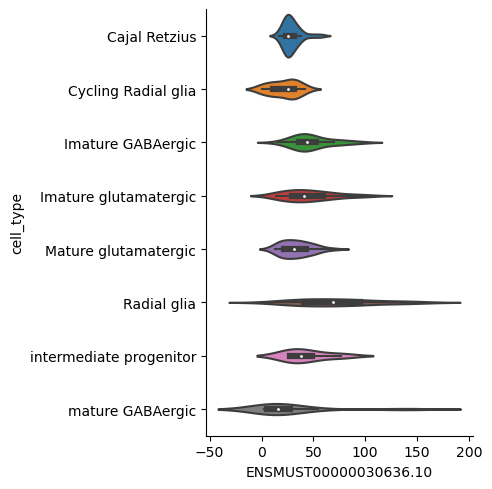

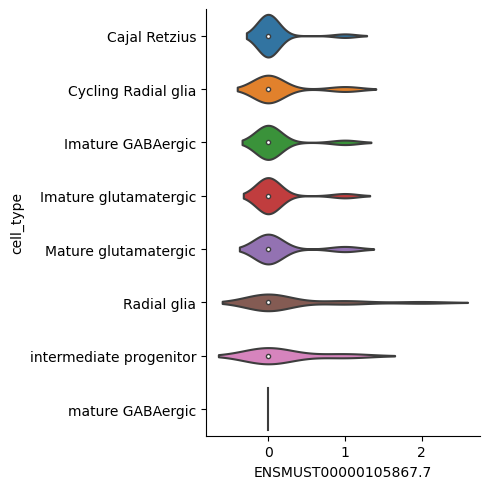

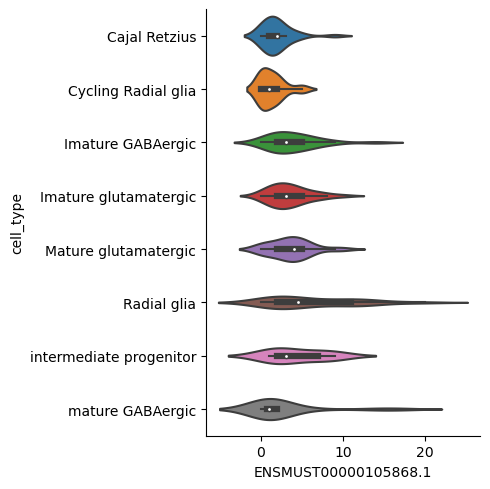

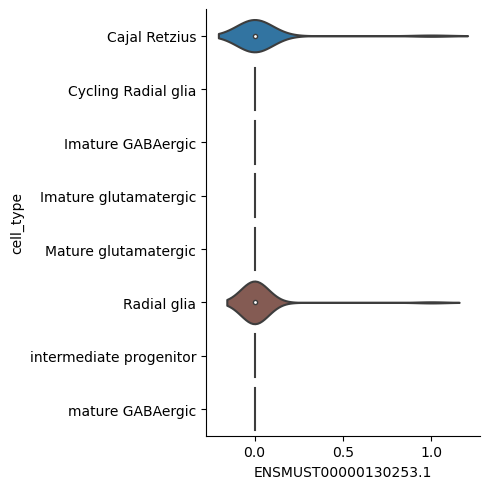

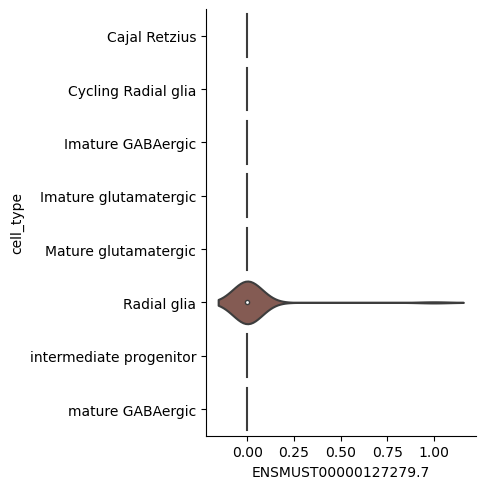

In [110]:
transcripts = ['ENSMUST00000030636.10', 'ENSMUST00000105867.7', 'ENSMUST00000105868.1', 'ENSMUST00000130253.1', 'ENSMUST00000127279.7']

i = 0
for t in transcripts:
    sns.catplot(kind='violin', data=gene_iso_count, x=t, y='cell_type', orient='h')
    i+=1


Umap showing the expression of transcripts

In [31]:
# mdata.mod['iso'].obsm['X_umap'] = mdata.mod['gen'].obsm['X_umap'] # not working! should redo Umap for transcripts?


/home/diamant/.conda/envs/iso_swt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1208: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


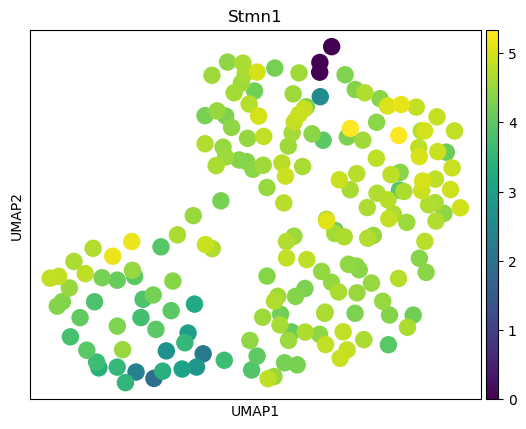

In [52]:
sc.pl.umap(mdata.mod['gen'], color=["Stmn1"])